Q-learning: model-free, off-policy. 
- learns the best (action, value) pairs given lots of exploration. 
- learn the value of each action
- can prove convergence to an optimal policy under certain conditions* read up on later

In [16]:
from collections import defaultdict
import gymnasium as gym
import numpy as np

class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env, 
        learning_rate: float, 
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95 
    ):
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor # how much to discount the future
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []

    def get_action(self, obs: tuple[int,int,bool]) -> int:
        # return random action with prob epsilon, best action otherwise
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs])) # returns indice with largest value
    
    def update(
        self,
        obs: tuple[int,int,bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int,int,bool]
    ):
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        # temporal diff = actual return - predicted value
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        ) 

        self.q_values[obs][action] += temporal_difference * self.lr
        # hm. if your q values aren't , temporal difference isn't a good loss signal?
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [22]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = gym.make("Blackjack-v1", sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [23]:
from tqdm import tqdm

# it is updating after every step, not episode
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.get_action(obs)

        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(obs,action,reward,terminated,next_obs)

        done = terminated or truncated
        obs = next_obs 

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:04<00:00, 24034.06it/s]


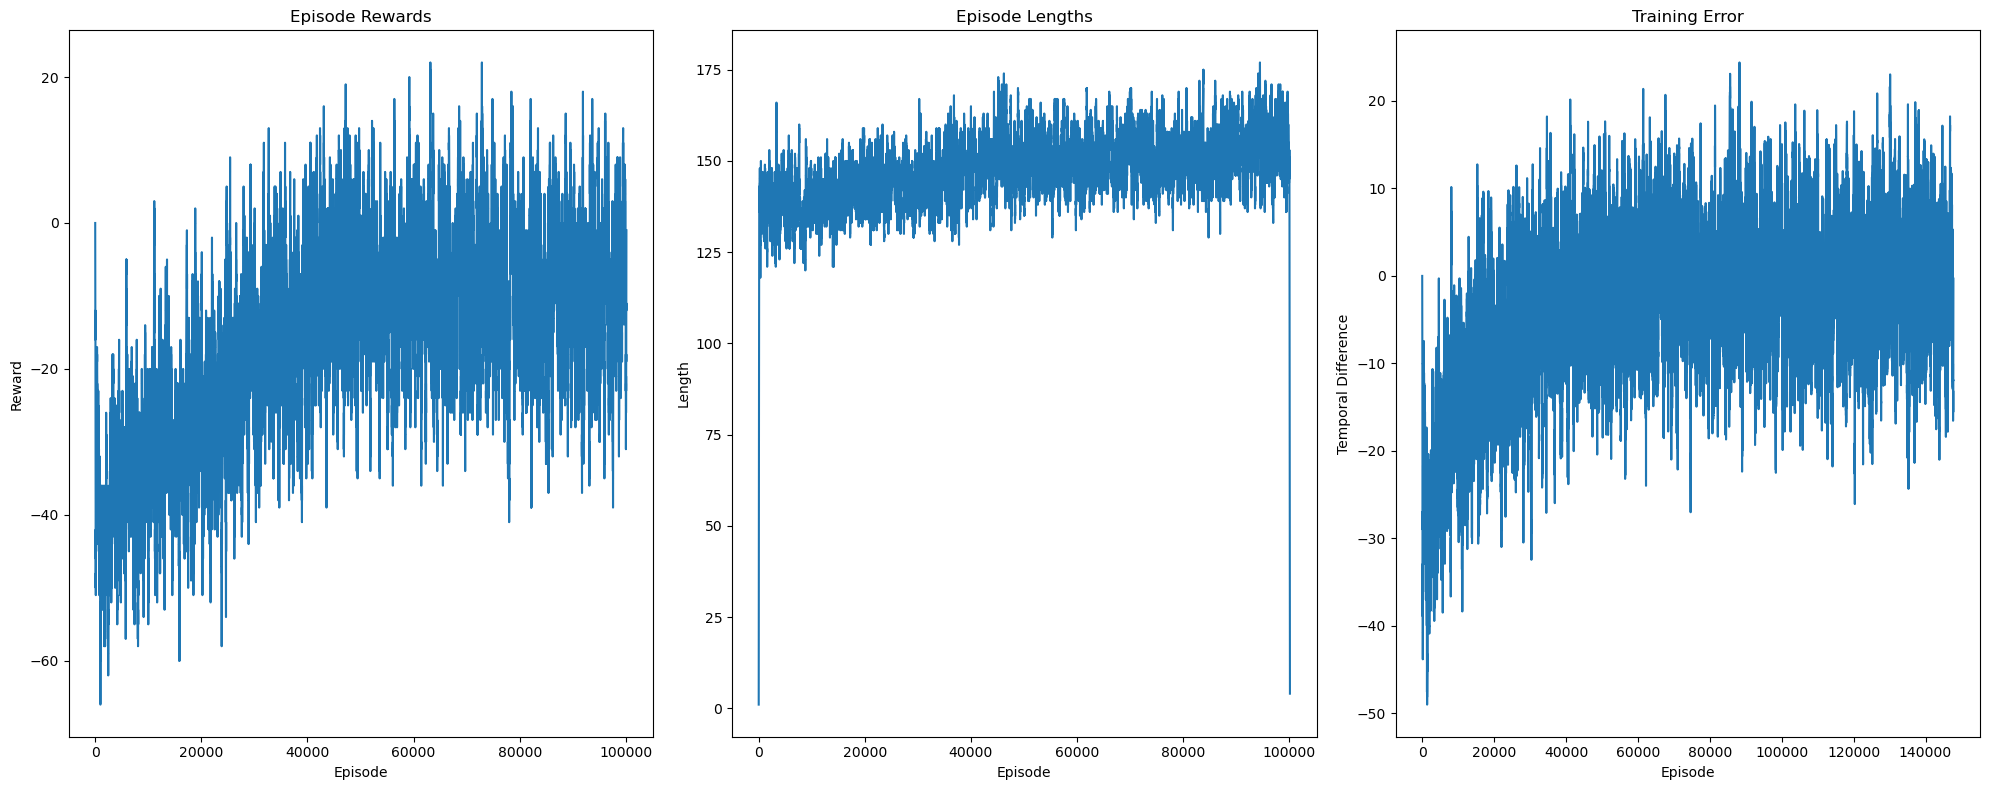

In [24]:
from matplotlib import pyplot as plt
# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# np.convolve will compute the rolling mean for 100 episodes

axs[0].plot(np.convolve(env.return_queue, np.ones(100)))
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(np.convolve(env.length_queue, np.ones(100)))
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

axs[2].plot(np.convolve(agent.training_error, np.ones(100)))
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()